This notebook handles the hard task. We tried many things, and as you will follow along you will see the different tasks we tried, our thought process and which were more succesfull. 


The main issue we saw for tracking the direction is that a person which appears in the first frame will most likely already be gone in the second frame. Therefore motion detection would be a better option

This code uses the OpenCV library to detect motion in a directory of JPEG images. It does this by comparing consecutive images and looking for changes in pixel values between the frames.
It seems to leave a ghost behind but it is not clear that if a person moves and is still in the frame, wether or not this "ghost" was his. Because of this we decided to try some other things.

In [4]:
import os
import cv2
import numpy as np

def motion_detector():
    frame_count = 0
    previous_frame = None
    image_directory = "data/1 Oude Fitness/partition 5"
    image_files = os.listdir(image_directory)

    for image_file in image_files:
        if image_file.endswith(".jpg"):
            frame_count += 1
            img_rgb = cv2.imread(os.path.join(image_directory, image_file))

            if ((frame_count % 2) == 0):
                prepared_frame = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
                prepared_frame = cv2.GaussianBlur(src=prepared_frame, ksize=(5,5), sigmaX=0)
                if (previous_frame is None):
                    previous_frame = prepared_frame
                    continue

                diff_frame = cv2.absdiff(src1=previous_frame, src2=prepared_frame)
                previous_frame = prepared_frame

                kernel = np.ones((5, 5))
                diff_frame = cv2.dilate(diff_frame, kernel, 1)

                thresh_frame = cv2.threshold(src=diff_frame, thresh=20, maxval=255, type=cv2.THRESH_BINARY)[1]

                contours, _ = cv2.findContours(image=thresh_frame, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(image=img_rgb, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
                contours, _ = cv2.findContours(image=thresh_frame, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    if cv2.contourArea(contour) < 50:
                        # too small: skip!
                        continue
                    (x, y, w, h) = cv2.boundingRect(contour)
                    cv2.rectangle(img=img_rgb, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=2)
                cv2.imshow('Motion detector', img_rgb)
                cv2.waitKey(0)

        if (cv2.waitKey(30) == 27):
            break
    cv2.destroyAllWindows()

motion_detector()

KeyboardInterrupt: 

This code uses the OpenCV library to calculate optical flow in a directory of JPEG images. However we ran into some issues with this code. It does seem to detect motion but we could not figure out how to optimize this model. As you will see when you run the code, it is not very accurate. For example, it doesn't seem to detect motion that good in the bottom right corner. We define feature points which are being tracked by the Lucas-Kanade optical flow algorithm. The algorithm uses the movement of these feature points between consecutive frames to calculate the optical flow, or the movement of objects in the image. In the code, it uses the function cv2.goodFeaturesToTrack() to detect good feature points in the first frame, then it uses cv2.calcOpticalFlowPyrLK() to track the feature points in the next frames. It will draw the feature points on the image as red dots, so the red dots will move due to the movement of the feature points.

Because we were not satisfied with this we also made a second visualization of motion detection in our third code block

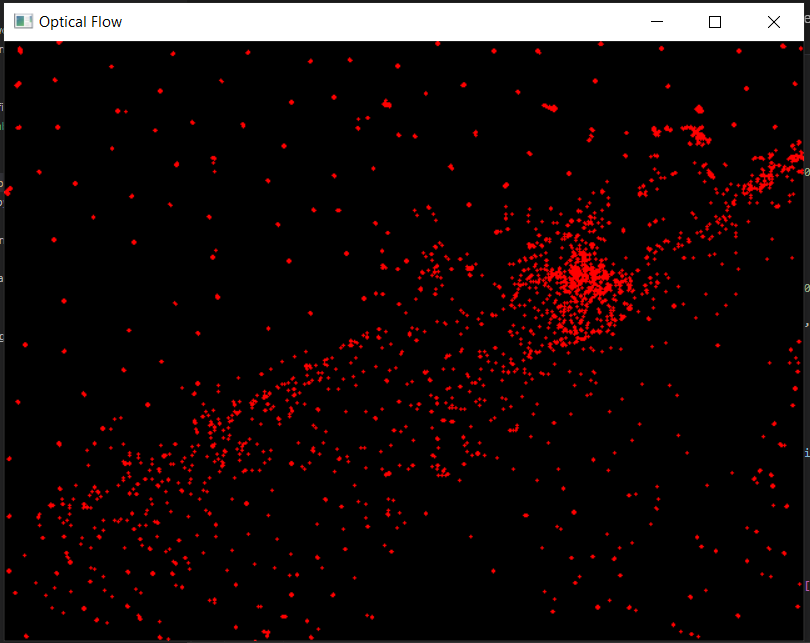

When running the code press any key to go through the images, u can also hold a key to go through them quickly. Press q to escape and end the program

In [ ]:
import os
import cv2
import numpy as np

image_directory = "data/1 Oude Fitness/partition 5"

prev_frame = cv2.imread(os.path.join(image_directory, os.listdir(image_directory)[0]))
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

flow_image = np.zeros_like(prev_frame)

lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

prev_points = cv2.goodFeaturesToTrack(prev_gray, maxCorners=300, qualityLevel=0.01, minDistance=30)

for image_path in os.listdir(image_directory):
    if image_path.endswith(".jpg"):
        frame = cv2.imread(os.path.join(image_directory, image_path))

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        curr_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)

        good_points = curr_points[status == 1]
        prev_points = good_points.reshape(-1, 1, 2)

        for i, (new, old) in enumerate(zip(good_points, prev_points)):
            a, b = new.ravel()
            c, d = old.ravel()
            flow_image = cv2.line(flow_image, (int(a), int(b)), (int(c), int(d)), [0, 0, 255], 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, [0, 0, 255], -1)

        prev_gray = gray

        cv2.imshow("Optical Flow", flow_image)
        cv2.imshow("Frame", frame)

        key = cv2.waitKey(0)

        if key == ord("q"):
            break

cv2.destroyAllWindows()

This code reads in a directory of JPG images and applies dense optical flow to detect motion in the images. The code uses the OpenCV library, and in particular the function cv2.calcOpticalFlowFarneback() to calculate the dense optical flow, which is the movement of every pixel in the frame.

We think this is the best visualization of motion detection we have. The only problem we seem to notice is that when the light changes, it shows the movement of the light. Which kind of makes sense because light can also be seen as movement. But this is not necessarily ideal for what we are trying to achieve.

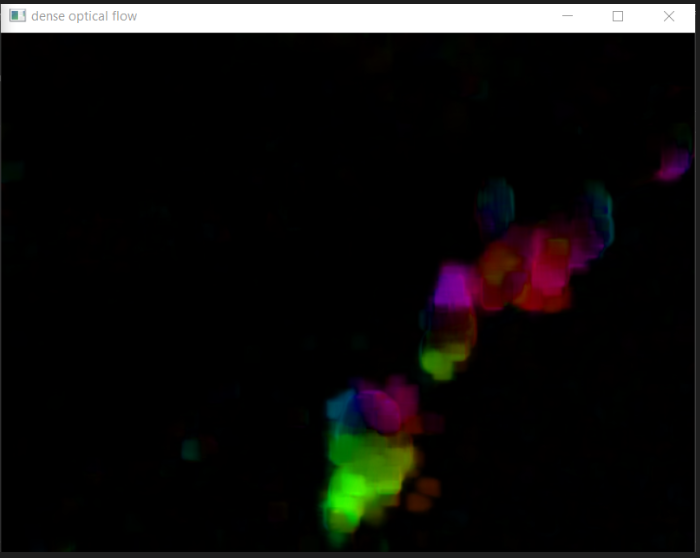

When running the code press any key to go through the images, u can also hold a key to go through them quickly. Press q to escape and end the program

In [1]:
import os
import cv2
import numpy as np

image_directory = "data/1 Oude Fitness/partition 5"

first_frame = cv2.imread(os.path.join(image_directory, os.listdir(image_directory)[0]))
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

mask = np.zeros_like(first_frame)

mask[..., 1] = 255

for i, image_path in enumerate(os.listdir(image_directory)):
    if image_path.endswith(".jpg"):
        frame = cv2.imread(os.path.join(image_directory, image_path))
        cv2.imshow("input", frame)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        mask[..., 0] = angle * 180 / np.pi / 2

        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

        cv2.imshow("dense optical flow", rgb)

        prev_gray = gray

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()